In [1]:
import itertools
from datetime import datetime

import submitit 

from auto_circuit.tasks import (
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
)
from elk_experiments.utils import repo_path_to_abs_path, OUTPUT_DIR
from elk_experiments.auto_circuit.tasks import IOI_TOKEN_CIRCUIT_TASK
from auto_circuit.types import AblationType
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc

# Specify Settings / Hyperpameters

In [2]:
#specify the hyperparameters
tasks = [
    IOI_TOKEN_CIRCUIT_TASK, 
    IOI_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    # IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # ANIMAL_DIET_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK
]
use_abs = [True, False]
names = [
    AblationType.RESAMPLE, 
    AblationType.TOKENWISE_MEAN_CLEAN,
    AblationType.TOKENWISE_MEAN_CORRUPT, 
    AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT,
    # AblationType.ZERO
]
grad_funcs = [
    GradFunc.LOGIT, 
    GradFunc.LOGPROB
]
answer_funcs = [
    AnswerFunc.MAX_DIFF, 
    AnswerFunc.AVG_VAL
]

use_abs_to_epsilon = {
    True: [0.1], 
    False: [0.0, -0.4]
}

# generate all combinations
combinations = [
    {
        "task": f"'{task.key}'",
        "use_abs": use_ab,
        "name": name.name,
        "grad_func": grad_func.name,
        "answer_func": answer_func.name,
        "epsilon": epsilon
    }
    for task, use_ab, ablation_type, grad_func, answer_func in itertools.product(
        tasks,
        use_abs,
        ablation_types,
        grad_funcs,
        answer_funcs
    )
    for epsilon in use_abs_to_epsilon[use_ab]
]

# combinations = [
#     {
#         "task": f"'{IOI_TOKEN_CIRCUIT_TASK.key}'",
#         "use_abs": False,
#         "ablation_type": AblationType.TOKENWISE_MEAN_CORRUPT.name,
#         "grad_func": GradFunc.LOGPROB.name,
#         "answer_func": AnswerFunc.AVG_VAL.name,
#         "epsilon": 0.0
#     }
# ]

# Setup Executor and Run

In [3]:
# setup the executor
out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_out_logs" / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
out_dir.mkdir(exist_ok=True, parents=True)
executor = submitit.AutoExecutor(folder=out_dir)
num_jobs_parallel = 8
executor.update_parameters(
    timeout_min=60*24,
    mem_gb=40,
    gres="gpu:1",
    cpus_per_task=8,
    nodes=1,
    slurm_qos="high", 
    slurm_array_parallelism=num_jobs_parallel
)


/nas/ucb/oliveradk/miniforge3/envs/elk-experiments/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [4]:
# run the jobs
with executor.batch():
    jobs = []
    for combo in combinations:
        function = submitit.helpers.CommandFunction(
            ["python", "scripts/hypothesis_tests.py"] + [
                f"{key}={value}" for key, value in combo.items()
            ], 
            cwd=repo_path_to_abs_path(".")
        )
        jobs.append(executor.submit(function))

In [8]:
len(jobs)

48

In [9]:
job = jobs[47]
# read stdout and stderr
print(job.stdout())
# print(job.stderr())

submitit INFO (2024-08-14 15:22:36,045) - Starting with JobEnvironment(job_id=432143_47, hostname=ppo.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-08-14 15:22:36,045) - Loading pickle: /nas/ucb/oliveradk/elk-experiments/output/hypo_test_out_logs/2024-08-14_14-45-35/432143_47_submitted.pkl
The following command is sent: "python scripts/hypothesis_tests.py task='Indirect Object Identification Component Circuit' use_abs=False ablation_type=TOKENWISE_MEAN_CLEAN_AND_CORRUPT grad_func=LOGPROB answer_func=AVG_VAL epsilon=-0.4"
Loaded pretrained model gpt2-small into HookedTransformer
seq_len before divergence None
seq_len after divergence None
Saving cache to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Indirect_Object_Identification_Component_Circuit_TOKENWISE_MEAN_CLEAN_AND_CORRUPT_LOGPROB_AVG_VAL_10/False_0.05_-0.4_0.9/prune_scores-14-08-2024_15-23-13.pkl
interval: 0 - 32491
width 1000
interval: 32000 - 32491
width 100
interval: 32400 -

# Analysize Results

## Aggregate Data

In [3]:
from auto_circuit.tasks import Task
def get_exp_dir(
    task_key: str,
    ablation_type: AblationType,
    grad_func: GradFunc,
    answer_func: AnswerFunc,
    ig_samples: int, 
    use_abs: bool,
    alpha: float,
    epsilon: float,
    q_star: float
):
    return repo_path_to_abs_path(
        OUTPUT_DIR / "hypo_test_results" / f"{task_key.replace(' ', '_')}_{ablation_type.name}_{grad_func.name}_{answer_func.name}_{ig_samples}" / f"{use_abs}_{alpha}_{epsilon}_{q_star}"
    )

In [119]:
def format_name(name: str | bool | float | int)->str:
    name = str(name)
    # set to uppercase for processing 
    name = name.upper()
    # remove TOKENWISE
    if name.startswith("TOKENWISE"):
        name = name[len("TOKENWISE_"):]
    # set MIN_EQUIV to NUM_EDGES 
    if name.startswith("MIN_EQUIV"):
        name = name.replace("MIN_EQUIV", "NUM_EDGES")

    # replace GRAD with OUPTUT 
    if name.startswith("GRAD"):
        name = name.replace("GRAD", "OUTPUT")
    # place FUNC with FUNCTION
    if name.endswith("FUNC"):
        name = name.replace("FUNC", "FUNCTION")
    # replace _ with space
    name = name.replace("_", " ")
    # upper case to title case
    name = name.title()
    return name

In [53]:
# combinations[-1]
min_equiv_results

{'A9.1->Resid End': {'not_minimal': False,
  'p_value': 1.0,
  'num_edge_score_gt_ref': 128,
  'diffs': [0.14733028411865234,
   0.14301729202270508,
   0.06535768508911133,
   0.042849063873291016,
   0.09846162796020508,
   0.02633380889892578,
   0.11009597778320312,
   0.11056709289550781,
   0.04281759262084961,
   0.07179737091064453,
   0.05104637145996094,
   0.057239532470703125,
   0.017157554626464844,
   0.03325605392456055,
   0.0166778564453125,
   0.1967310905456543,
   0.07823467254638672,
   0.09741353988647461,
   0.03494977951049805,
   0.08651447296142578,
   0.19961166381835938,
   0.12262296676635742,
   0.14655113220214844,
   0.016766071319580078,
   0.04319334030151367,
   0.0753011703491211,
   0.1456012725830078,
   0.2012944221496582,
   0.19692564010620117,
   0.19582366943359375,
   0.09962081909179688,
   0.09105825424194336,
   0.19022512435913086,
   0.06413841247558594,
   0.10950708389282227,
   0.1738729476928711,
   0.19913101196289062,
   0.0793070

In [63]:
import pandas as pd
import json

ig_default = 10
alpha_default = 0.05
q_star_default = 0.9

# Create a list to store the data
data = []
for combo in combinations:
    task_key = combo["task"][1:-1]  # strip quotes
    ablation_type = AblationType[combo["ablation_type"]]
    grad_func = GradFunc[combo["grad_func"]]
    answer_func = AnswerFunc[combo["answer_func"]]
    use_ab = combo["use_abs"]
    epsilon = combo["epsilon"]

    # get path to results 
    exp_path = get_exp_dir(task_key, ablation_type, grad_func, answer_func, ig_default, use_ab, alpha_default, epsilon, q_star_default)

    # load equiv test results 
    with open(exp_path / "equiv_results.json", "r") as f:
        equiv_test_results: dict[int, dict] = json.load(f)
    
    # load min_equiv results
    min_test_path = exp_path / "min_test_results.json"
    if not min_test_path.exists():
        all_minimal = False
        min_mean_p_value = None
    else:
        with open(min_test_path, "r") as f:
            min_equiv_results: dict[int, dict] = json.load(f)
            all_minimal = all(not v['not_minimal'] for v in min_equiv_results.values())
            min_mean_p_value = sum(v['p_value'] for v in min_equiv_results.values()) / len(min_equiv_results)
    
    # load independence results 
    indep_test_path = exp_path / "indep_result.json"
    if not indep_test_path.exists():
        indep = False
    else:
        with open(exp_path / "indep_result.json", "r") as f:
            indep_test_results: dict[int, dict] = json.load(f)
            indep = not indep_test_results["not_indep"]
            indep_p_value = indep_test_results["p_value"]



    total_edges = max([int(edge_count) for edge_count in equiv_test_results.keys()])
    equivs = [int(edge_count) for edge_count, result in equiv_test_results.items() if not result["not_equiv"]]
    min_equiv = min(equivs) if len(equivs) > 0 else total_edges

    # Append the data as a dictionary
    data.append({
        'task_key': task_key,
        'use_abs': use_ab,
        'epsilon': epsilon,
        'ablation_type': ablation_type.name,
        'answer_func': answer_func.name,
        'grad_func': grad_func.name,
        'frac_total_edges': min_equiv / total_edges,
        'min_equiv': min_equiv,
        'total_edges': total_edges, 
        'all_minimal': all_minimal, 
        'min_mean_p_value': min_mean_p_value,
        'indep': indep, 
        'indep_p_value': indep_p_value

    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Set a multi-index
df.set_index(['task_key', 'use_abs', 'epsilon', 'ablation_type', 'answer_func', 'grad_func'], inplace=True)

### Edge Counts for all Tasks, All Partitions

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_fraction_edges(df):
    scale = 'log'  # or 'linear'

    def limit_image_size(fig, ax, max_size=65000):
        while True:
            fig.canvas.draw()
            width, height = fig.canvas.get_width_height()
            if width <= max_size and height <= max_size:
                break
            fig_size = fig.get_size_inches()
            fig.set_size_inches(fig_size[0] * 0.9, fig_size[1] * 0.9)
        return fig, ax

    # Get unique combinations
    use_abs = df.index.get_level_values('use_abs').unique()
    epsilons = df.index.get_level_values('epsilon').unique()
    ablation_types = df.index.get_level_values('ablation_type').unique()
    answer_funcs = df.index.get_level_values('answer_func').unique()
    grad_funcs = df.index.get_level_values('grad_func').unique()
    task_keys = df.index.get_level_values('task_key').unique()

    ablation_answer_combinations = list(itertools.product(ablation_types, answer_funcs, grad_funcs))

    for use_ab in use_abs:
        for epsilon in epsilons:
            fig, ax = plt.subplots(figsize=(16, 9), dpi=100)
            index = np.arange(len(task_keys))
            bar_width = 0.8 / len(ablation_answer_combinations)
            opacity = 0.8

            plotted_combinations = 0  # Counter for actually plotted combinations

            for i, combination in enumerate(ablation_answer_combinations):
                ablation_type, answer_func, grad_func = combination
                
                # Filter the DataFrame
                mask = (df.index.get_level_values('use_abs') == use_ab) & \
                       (df.index.get_level_values('epsilon') == epsilon) & \
                       (df.index.get_level_values('ablation_type') == ablation_type) & \
                       (df.index.get_level_values('answer_func') == answer_func) & \
                       (df.index.get_level_values('grad_func') == grad_func)
                
                subset = df[mask]
                
                if not subset.empty:
                    values = subset['frac_total_edges'].values
                    task_indices = np.array([np.where(task_keys == task)[0][0] for task in subset.index.get_level_values('task_key')])
                    
                    position = task_indices + (plotted_combinations - len(ablation_answer_combinations)/2 + 0.5) * bar_width
                    
                    ax.bar(position, values, bar_width,
                           alpha=opacity,
                           label=f'{ablation_type} & {answer_func} % {grad_func}')
                    
                    plotted_combinations += 1

            if plotted_combinations == 0:
                plt.close(fig)
                continue  # Skip to the next iteration if no data was plotted

            ax.set_xlabel('Tasks')
            ax.set_ylabel('Fraction of Total Edges')
            ax.set_title(f'Fraction of Total Edges by Task (use_ab={use_ab}, epsilon={epsilon})')
            ax.set_xticks(index)
            ax.set_xticklabels(task_keys, rotation=90, ha='center', fontsize=8)
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
            ax.set_yscale(scale)
            
            plt.tight_layout()
            plt.subplots_adjust(right=0.75)
            
            fig, ax = limit_image_size(fig, ax)
            
            plt.savefig(f'fraction_edges_use_ab_{use_ab}_epsilon_{epsilon}.png', 
                        bbox_inches='tight', 
                        dpi=100)
            plt.close(fig)

    print("All figures have been generated and saved.")

# Usage
plot_fraction_edges(df)

All figures have been generated and saved.


## Relative Edge Counts Across Paritions

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, Tuple, List, Any

def flexible_normalize_aggregate_and_plot(
    df,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 0,
    ha: str = 'center',
    custom_filters: Dict[str, List] = None
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Aggregate data
    agg_data = df_reset.groupby(agg_by)[f'normalized_{value_column}'].agg(['mean', 'median', list]).reset_index()
    
    # Sort by mean
    agg_data = agg_data.sort_values('mean', ascending=True)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate x-positions for evenly spaced columns, including phantom columns
    num_columns = len(agg_data)
    x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
    
    for i, (_, row) in enumerate(agg_data.iterrows()):
        # Plot individual points with reduced opacity
        ax.scatter([x_positions[i]] * len(row['list']), row['list'], alpha=0.3, color='blue')
        
        # Plot mean with a red point
        ax.scatter(x_positions[i], row['mean'], color='red', s=100, zorder=3, marker='o')
        
        # Plot median with a green triangle
        ax.scatter(x_positions[i], row['median'], color='green', s=100, zorder=3, marker='^')
    
    ax.set_xlabel(" and ".join(agg_by))
    ax.set_ylabel(f'Normalized {value_column}')
    title = f'Normalized {value_column} by {" and ".join(agg_by)}'
    if custom_filters:
        filter_desc = ', '.join([f"{k}≠{v}" for k, v in custom_filters.items()])
        title += f' (Filtered: {filter_desc})'
    ax.set_title(title)
    
    # Set x-ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [" and ".join([str(row[col]) for col in agg_by]) for _, row in agg_data.iterrows()],
        rotation=rotation,
        ha=ha
    )
    
    # Set x-axis limits
    ax.set_xlim(0, 1)
    
    # Set y-axis limits from 0 to 1 for normalized data
    ax.set_ylim(0, 1)
    
    # Add a legend
    ax.scatter([], [], color='blue', alpha=0.3, label='Individual data points')
    ax.scatter([], [], color='red', s=100, marker='o', label='Mean')
    ax.scatter([], [], color='green', s=100, marker='^', label='Median')
    ax.legend()
    
    plt.tight_layout()
    # plt.show()

    return fig, ax

# Example usage:
# flexible_normalize_aggregate_and_plot(
#     df,
#     agg_by=['ablation_type', 'answer_func', 'grad_func'],
#     value_column='frac_total_edges',
#     normalize_by=['task_key', 'use_abs', 'epsilon'],
#     rotation=45,
#     ha='right',
#     custom_filters={'epsilon': [-0.4]}
# )

### By Ablation Type

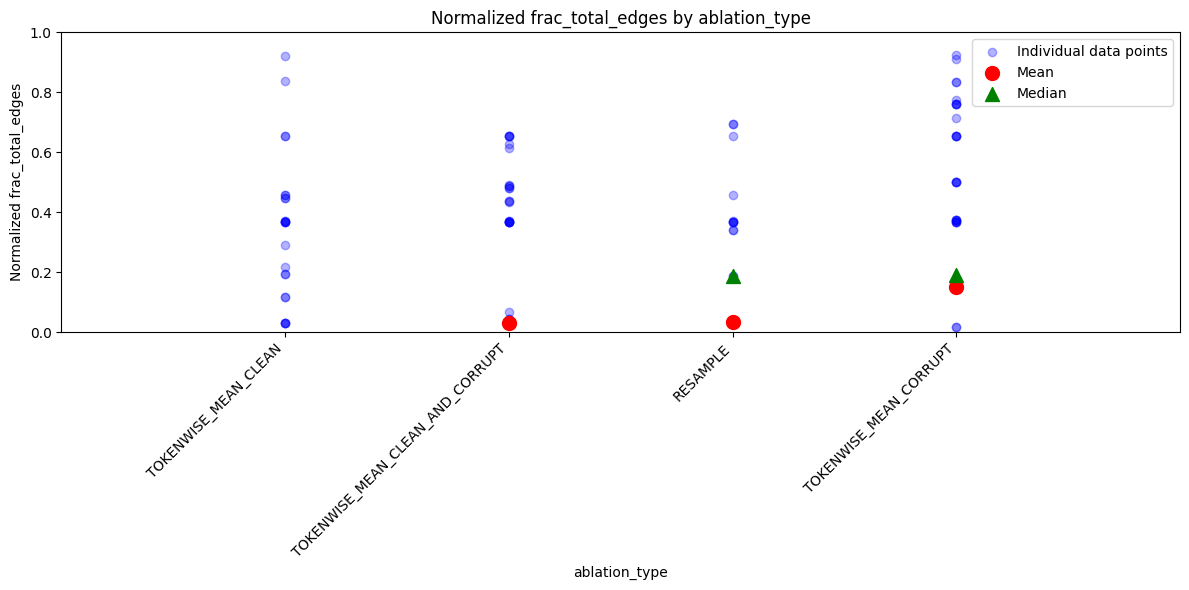

In [74]:
# Example usage:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right', 
)

thoughts - no clear winner, not too much data, though the fact that mean corrupt tends to be smaller does make sense (doesn't need to infer task)

### By Output Function (LogProb vs Logit)

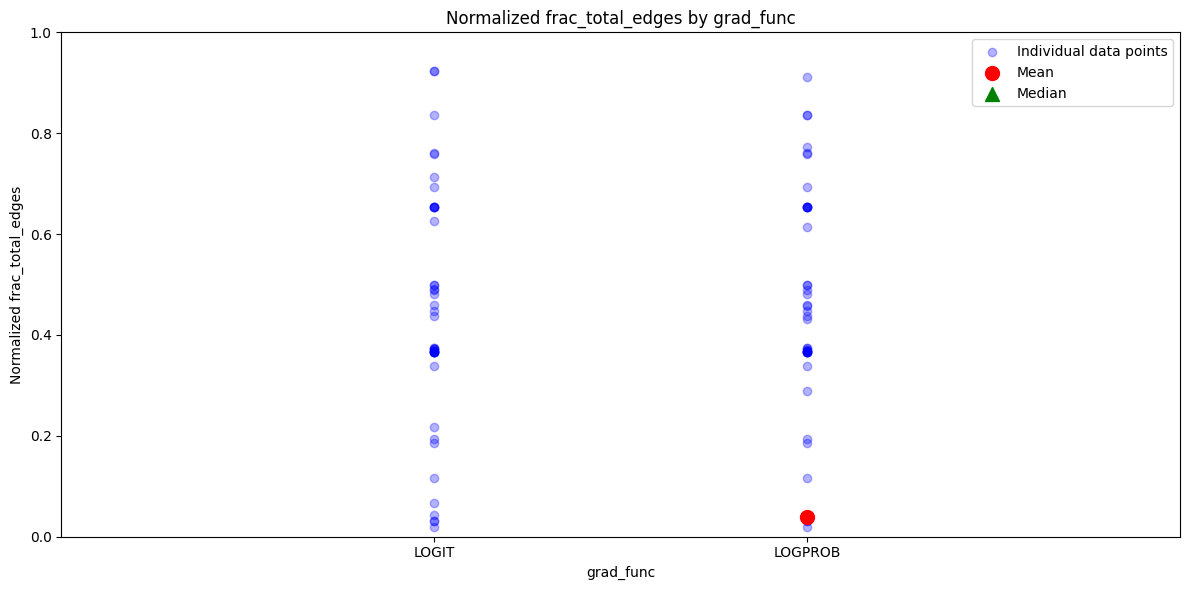

In [75]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

obviously no clear winners, but lots of variation

### Compare Answer Functions 

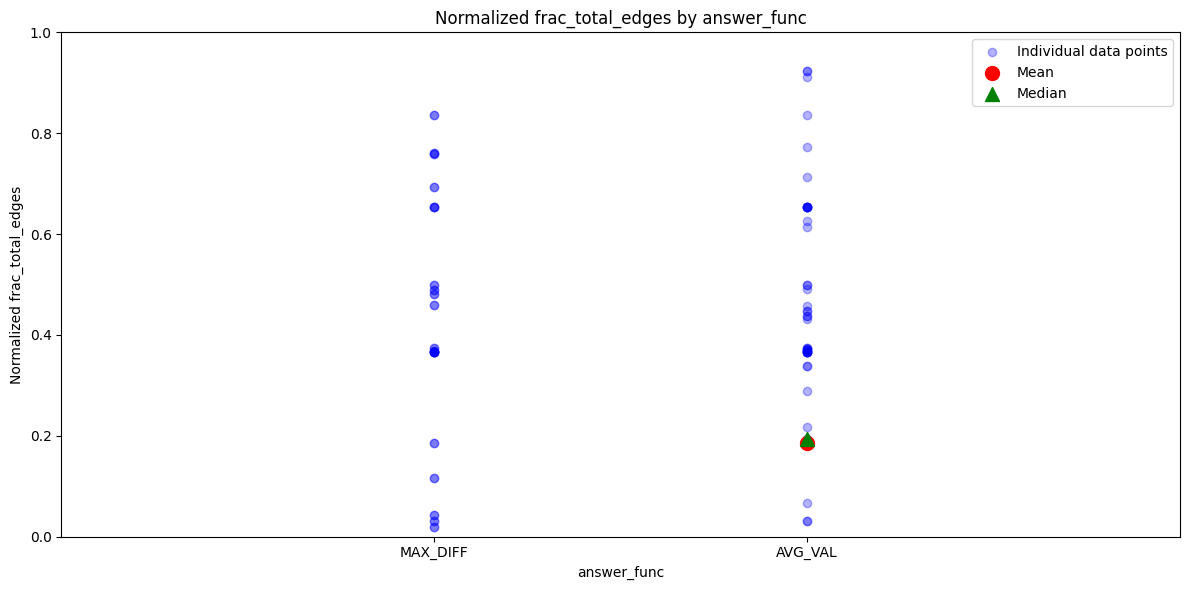

In [76]:
# Example usage:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

I guess I would have predicted max diff would have more of an advantage - maybe I should be looking at token only? idk

### Output Function x Answer Function

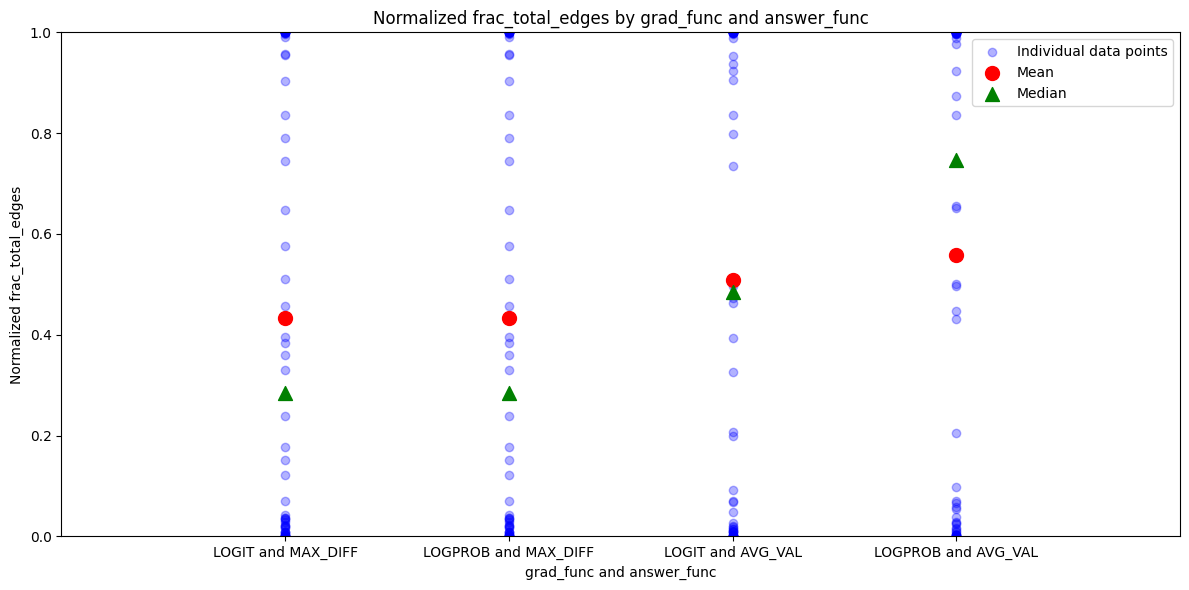

In [142]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=0,
    ha='center'
)

### Output Function x Answer Function x Ablation Type 

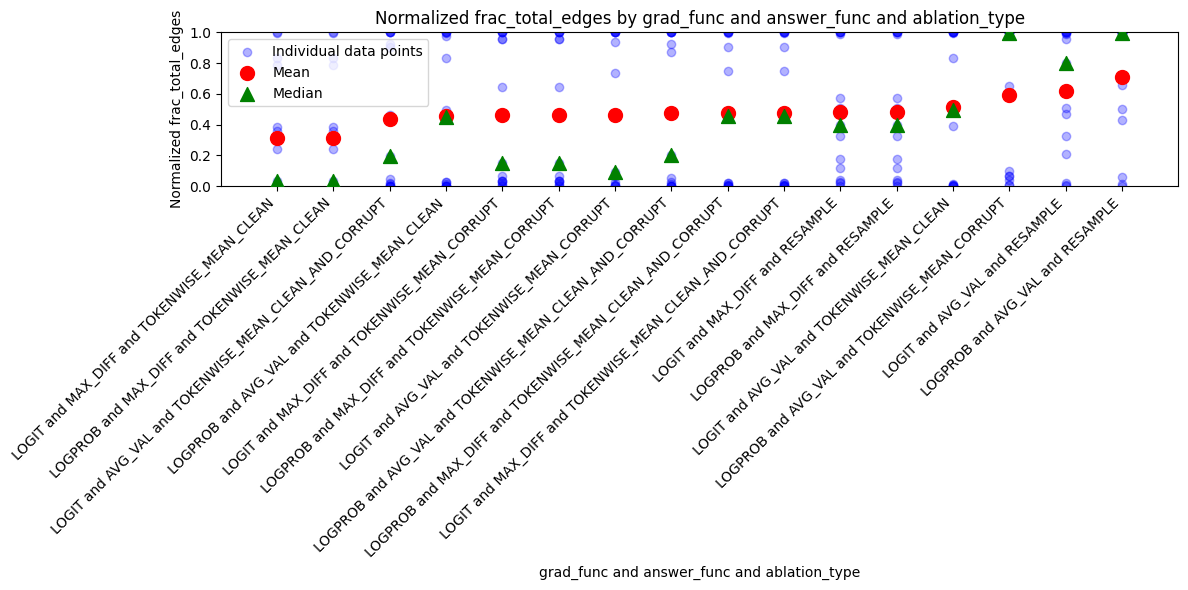

In [143]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['grad_func', 'answer_func', 'ablation_type'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right'
)

ok I could probably stare at it more but no super discernable synergies, seems like some methods are marignally "better", those difference roughly compound

### Abs vs Postive Only
What I want - aggregatae across 

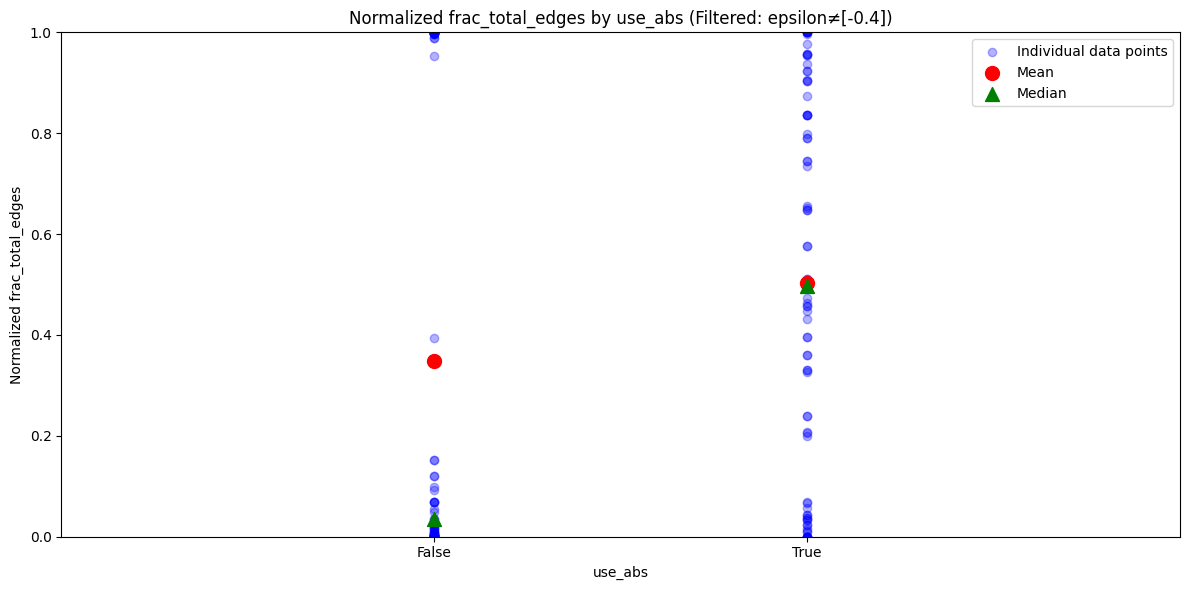

In [144]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['use_abs'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [-0.4]}
)

## Abs 0.0 vs 0.4 

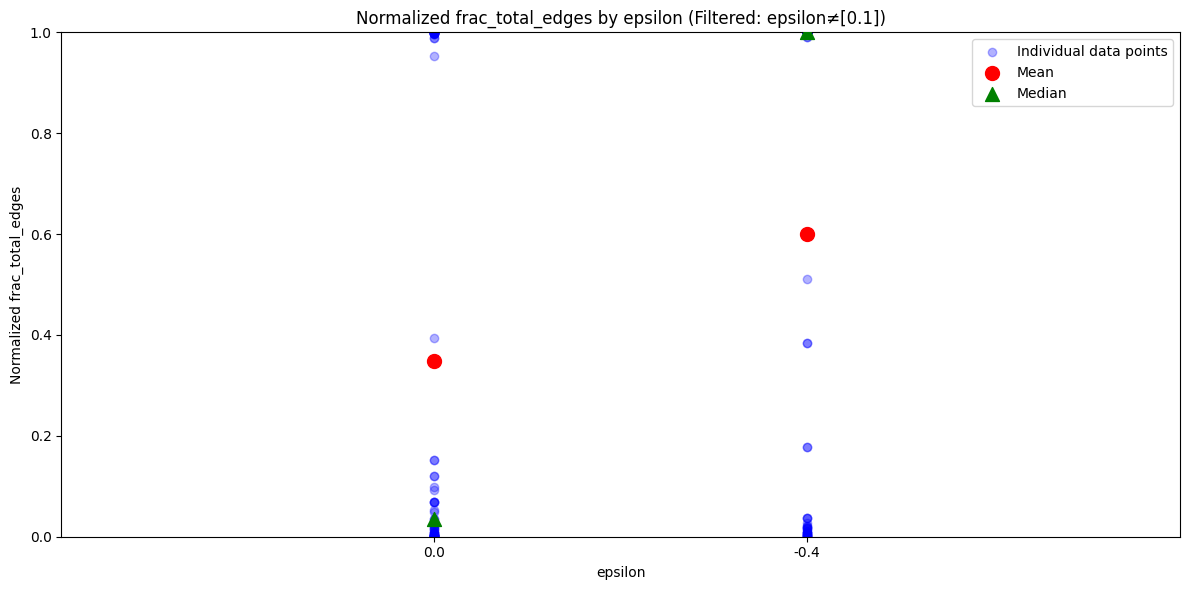

In [145]:
flexible_normalize_aggregate_and_plot(
    df,
    agg_by=['epsilon'],
    value_column='frac_total_edges',
    normalize_by=['task_key', 'epsilon'],
    rotation=0,
    ha='center', 
    custom_filters={'epsilon': [0.1]}
)

## Minimality and Completeness Statistics

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def create_category_pie_charts(data, title: str, ignore_categories=None, figsize=(20, 15)):
    """
    Create a grid of pie charts, one for each category in the data.
    
    :param data: A pandas DataFrame with a multi-index as described in the input data.
    :param ignore_categories: Optional list of categories to ignore in the charts.
    :param figsize: Tuple specifying the figure size (width, height).
    :return: None (displays the charts)
    """
    if ignore_categories is None:
        ignore_categories = []
    
    # Get all categories (index names)
    categories = [cat for cat in data.index.names if cat not in ignore_categories]
    
    # Calculate number of rows and columns for subplots
    n_charts = len(categories)
    n_cols = 3  # You can adjust this for different layouts
    n_rows = (n_charts - 1) // n_cols + 1
    
    # Set up the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Create a pie chart for each category
    for i, category in enumerate(categories):
        ax = axes[i]
        
        # Get value counts and calculate fractions
        value_counts = data.groupby(level=category).size()
        fractions = value_counts / value_counts.sum()
        
        # apply format names to fractions
        fractions.index = fractions.index.map(format_name)
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(fractions, autopct='%1.1f%%', textprops=dict(color="w"))
        
        # Add category name as title
        ax.set_title(format_name(category))
        
        # Add legend
        ax.legend(wedges, fractions.index, title="Values", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [47]:
# minimal circuits
minimal_df = df[df['all_minimal']]
true_minimal_df = minimal_df[minimal_df['frac_total_edges'] < 0.5] # likely minimal b/c complement edges very small impact, not counting for now
true_minimal_tested_df = true_minimal_df[true_minimal_df['min_equiv'] <= 500] # minimal circuits fully tested (we only test up to 500 edges)
true_mimimal_untested = true_minimal_df[true_minimal_df['min_equiv'] > 500] # minimal circuits not fully tested (TODO test)

In [7]:
len(minimal_df), len(true_minimal_df), len(true_minimal_tested_df), len(true_mimimal_untested)

(124, 92, 74, 18)

In [8]:
# independent circuits 
indep_df = df[df['indep']]
indep_and_true_minimal_df = indep_df[indep_df.index.isin(true_minimal_df.index)]
indep_and_true_tested_minimal_df = indep_df[indep_df.index.isin(true_minimal_tested_df.index)]
indep_and_true_untested_minimal_df = indep_df[indep_df.index.isin(true_mimimal_untested.index)]

In [9]:
len(indep_and_true_minimal_df), len(indep_and_true_tested_minimal_df), len(indep_and_true_untested_minimal_df)

(55, 51, 4)

In [27]:
indep_and_true_minimal_df = true_minimal_df[true_minimal_df['indep']]
len(indep_and_true_minimal_df)

55

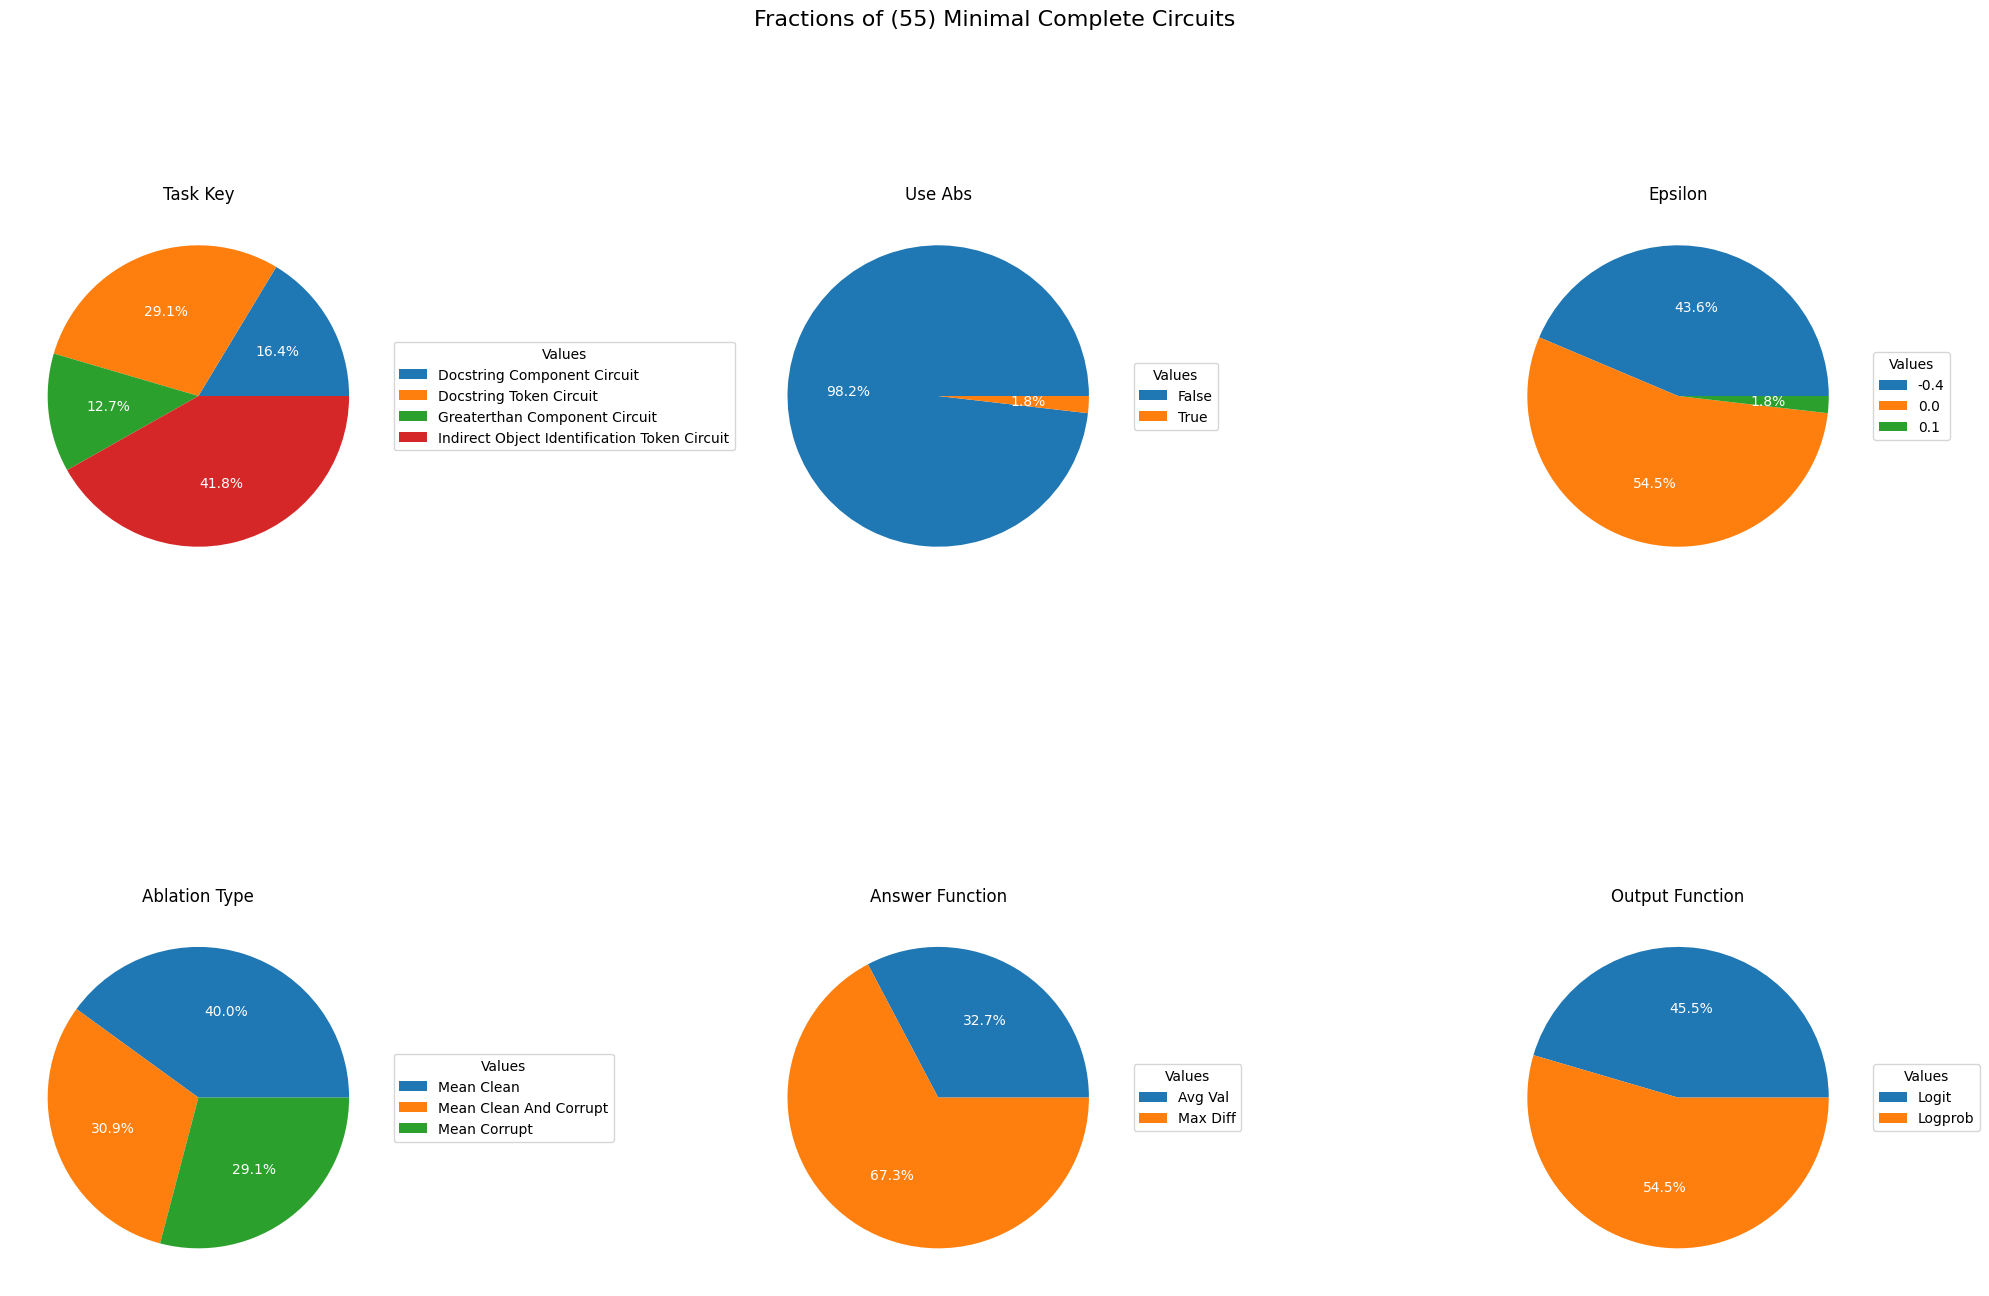

In [49]:
#TODO: make nice at to paper (I think we can basically keep it to this)
create_category_pie_charts(indep_and_true_minimal_df, title=f"Fractions of ({len(indep_and_true_minimal_df)}) Minimal Complete Circuits")

In [143]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Any
import pandas as pd

def flexible_normalize_and_plot_categories(
    df: pd.DataFrame,
    agg_by: List[str],
    value_column: str = 'frac_total_edges',
    normalize_by: List[str] = None,
    rotation: int = 45,
    ha: str = 'right',
    custom_filters: Dict[str, List] = None,
    figsize: tuple = (20, 10),  # Decreased height
    n_cols: int = 3,
    show_individual_points: bool = True,
    show_std_dev: bool = False
):
    # Reset index to access all columns
    df_reset = df.reset_index()
    
    # Apply custom filters
    if custom_filters:
        for column, values in custom_filters.items():
            df_reset = df_reset[~df_reset[column].isin(values)]
    
    # Normalize data if normalize_by is provided
    if normalize_by:
        df_reset[f'normalized_{value_column}'] = df_reset.groupby(normalize_by)[value_column].transform(
            lambda x: x / x.max()
        )
    else:
        df_reset[f'normalized_{value_column}'] = df_reset[value_column]
    
    # Calculate number of rows and columns for subplots
    n_charts = len(agg_by)
    n_rows = (n_charts - 1) // n_cols + 1
    
    # Set up the plot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex='col', sharey='row', squeeze=False)
    # fig.suptitle(f'Normalized {value_column} by Categories', fontsize=16)
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    # Create a scatter plot for each category
    for i, category in enumerate(agg_by):
        ax = axes[i]
        
        # Aggregate data for this category
        agg_data = df_reset.groupby(category)[f'normalized_{value_column}'].agg(['mean', 'median', 'std', list]).reset_index()
        agg_data = agg_data.sort_values('mean', ascending=True)
        
        # Calculate x-positions for evenly spaced columns
        num_columns = len(agg_data)
        x_positions = np.linspace(0, 1, num_columns + 2)[1:-1]  # Remove phantom columns
        
        for j, (_, row) in enumerate(agg_data.iterrows()):
            # Plot individual points with reduced opacity if show_individual_points is True
            if show_individual_points:
                ax.scatter([x_positions[j]] * len(row['list']), row['list'], alpha=0.3, color='blue')
            
            # Plot mean with a red point
            ax.scatter(x_positions[j], row['mean'], color='red', s=50, zorder=3, marker='o')
            
            # Plot median with a green triangle
            ax.scatter(x_positions[j], row['median'], color='green', s=50, zorder=3, marker='^')
            
            # Plot standard deviation if show_std_dev is True
            if show_std_dev:
                ax.errorbar(x_positions[j], row['mean'], yerr=row['std'], color='black', capsize=5, capthick=2, fmt='none', zorder=2)
        
        # Set title and labels
        # ax.set_title(category)
        ax.set_xlabel(format_name(category))
        # move x label to above plot
        ax.xaxis.set_label_position('top')
        if i % n_cols == 0:  # Only set ylabel for the leftmost subplot in each row
            ax.set_ylabel(f'Normalized {format_name(value_column)}')
        
        # Set x-ticks and labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(agg_data[category].map(format_name), rotation=rotation, ha=ha)
        
        
        # Set axis limits
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # Remove box around the plot
        for spine in ax.spines.values():
            spine.set_visible(False)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Add a legend to the figure
    legend_elements = []
    if show_individual_points:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Individual data points',
                                          markerfacecolor='blue', markersize=8, alpha=0.3))
    legend_elements.extend([
        plt.Line2D([0], [0], marker='o', color='w', label='Mean', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='^', color='w', label='Median', markerfacecolor='green', markersize=8)
    ])
    if show_std_dev:
        legend_elements.append(plt.Line2D([0], [0], color='black', label='Standard Deviation'))
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.25))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1)
    return fig, axes

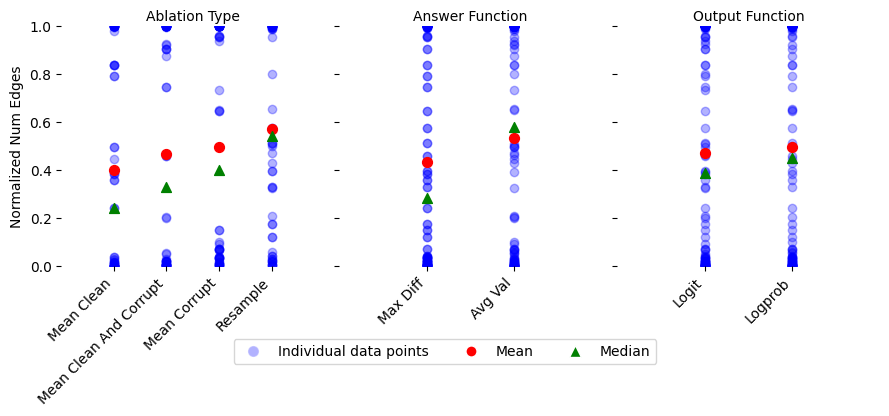

In [148]:
# Example usage:
fig, axes = flexible_normalize_and_plot_categories(
    df,
    agg_by=['ablation_type', 'answer_func', 'grad_func'],
    value_column='min_equiv',
    normalize_by=['task_key', 'use_abs', 'epsilon'],
    rotation=45,
    ha='right',
    figsize=(9, 3),
    n_cols=3
)

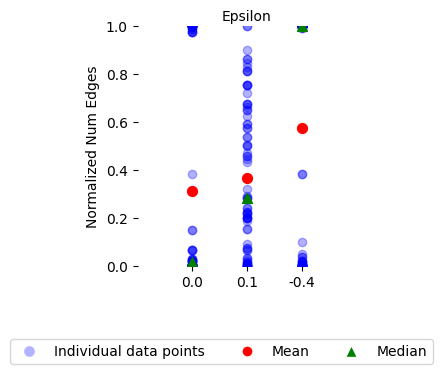

In [149]:
# Example usage:
fig, axes = flexible_normalize_and_plot_categories(
    df,
    agg_by=['epsilon'],
    value_column='min_equiv',
    normalize_by=['task_key'],
    rotation=0,
    ha='center',
    figsize=(3, 3),
    n_cols=1
)

# Minimality vs Independence 
(Not using for now)

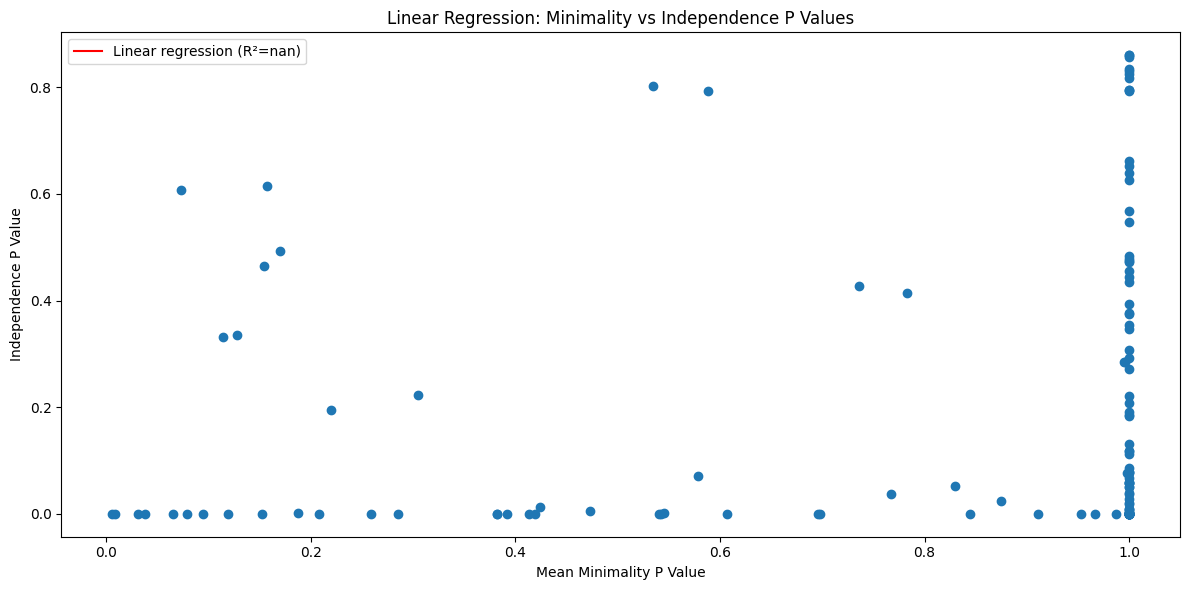

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# wait high p value for min implies minimal 
# high p value for indep implies independent
# Assuming df is already defined and contains the necessary data
df_sorted = df[df['frac_total_edges'] < 0.5]
df_sorted = df_sorted.sort_values('min_mean_p_value', ascending=False, inplace=False)

# filter p values > .95 out 
# df = df[df['min_mean_p_value'] < 0.95]

fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot
ax.scatter(df_sorted['min_mean_p_value'], df_sorted['indep_p_value'])

# Calculate and plot linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df['min_mean_p_value'], df['indep_p_value'])
line = slope * df['min_mean_p_value'] + intercept
ax.plot(df['min_mean_p_value'], line, color='r', label=f'Linear regression (R²={r_value**2:.3f})')

ax.set_xlabel('Mean Minimality P Value')
ax.set_ylabel('Independence P Value')
# ax.invert_xaxis()
# # ax.invert_yaxis()

ax.legend()
plt.title('Linear Regression: Minimality vs Independence P Values')
plt.tight_layout()
plt.show()

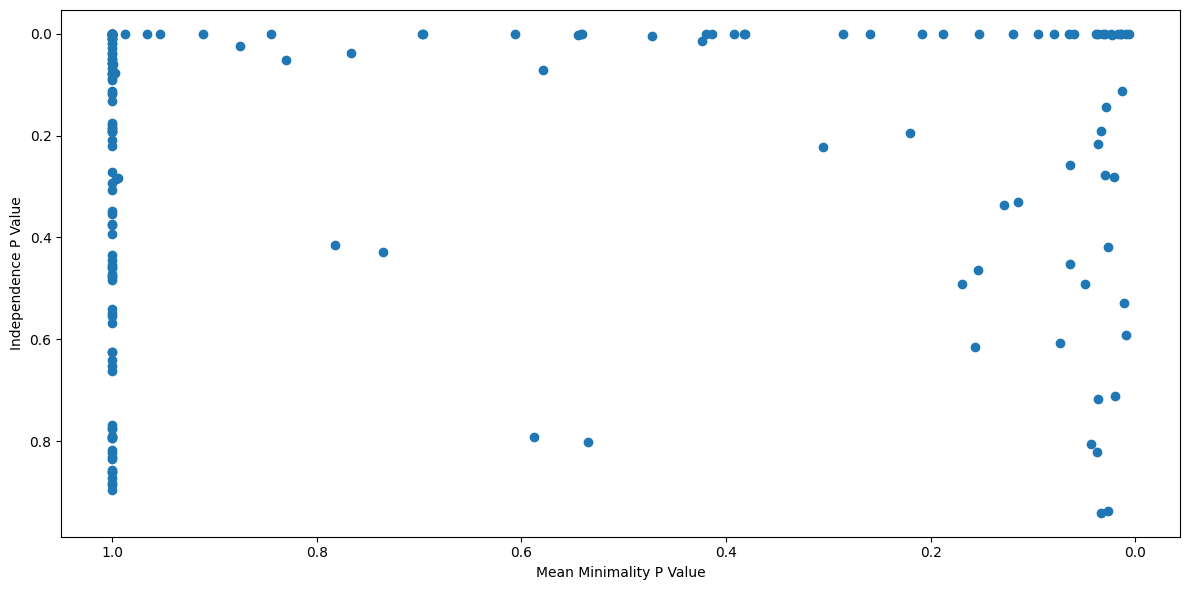

In [57]:
from scipy import stats

# sorted by minimality p value, plot independence p value
df = df.sort_values('min_mean_p_value', ascending=False, inplace=False)

# low min p value means not minimal 
# low independence p value means not independent
# plot min_mean_p_value on x axis and indep_p_value on y axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['min_mean_p_value'], df['indep_p_value'])
ax.set_xlabel('Mean Minimality P Value')
ax.set_ylabel('Independence P Value')
# invert x axis and y axis 
ax.invert_xaxis()
ax.invert_yaxis()
# plot trend line 
plt.tight_layout()
plt.show()